### Notes (open tasks):

- ~AUC-Metric~ 
- ~Average Metric over all Tasks~  
- ~Check Tensorboard~ (open anaconda -> move to pw dir -> python -m tensorboard.main --logdir=runs
- find a good naming pattern for models, to check which config params were used (for tensorboard)
- Hyperparameter search
- train model and baseline over 10 different seeds and avg over their performances
- Report 

### Imports

In [1]:
seed = 42

import os
import json
import numpy as np
import pandas as pd

import torch as torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score, f1_score, average_precision_score

from fs_model import Model
from dataset_modul import Dataset
from preprocessing import preprocessing
from utils import data_split, acc_f1, flatten,train_rf, dauc_pr, auc_score, train_model, combined_metrics, eval_rf

### Cuda settings

In [2]:
# use cuda
if torch.cuda.is_available():
    device_id = torch.cuda.current_device()
    device = torch.device('cuda:%d' % device_id)
    print(torch.cuda.get_device_name(device_id))
else:
    device = torch.device('cpu')

NVIDIA GeForce RTX 4060 Ti


# 1. Load Dataset

In [3]:
# SIDER Dataset

# 1.5 k mols, 27 tasks, 39,956 measurements

sider = pd.read_csv("datasets/sider.csv")

print('Shape: ', sider.shape)

vals = sider.values.flatten()
print('Measurments: ', len([v for v in vals if str(v) != 'nan']))

sider.head() 

Shape:  (1427, 28)
Measurments:  39956


,smiles,Hepatobiliary disorders,Metabolism and nutrition disorders,Product issues,Eye disorders,Investigations,Musculoskeletal and connective tissue disorders,Gastrointestinal disorders,Social circumstances,Immune system disorders,...,"Congenital, familial and genetic disorders",Infections and infestations,"Respiratory, thoracic and mediastinal disorders",Psychiatric disorders,Renal and urinary disorders,"Pregnancy, puerperium and perinatal conditions",Ear and labyrinth disorders,Cardiac disorders,Nervous system disorders,"Injury, poisoning and procedural complications"
0,C(CNCCNCCNCCN)N,1,1,0,0,1,1,1,0,0,...,0,0,1,1,0,0,1,1,1,0
1,CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...,0,1,0,0,1,1,1,0,0,...,0,1,1,0,0,0,1,0,1,0
2,CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O...,0,1,0,1,1,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
3,CCC12CC(=C)C3C(C1CC[C@]2(C#C)O)CCC4=CC(=O)CCC34,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,0,0,1,1
4,C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O,1,1,0,1,1,1,1,0,1,...,0,1,1,1,0,0,1,0,1,0


In [4]:
# Percentage of actives and inactives per task

show = False

percentage_df = pd.DataFrame()

if show:    
    
    for col in sider.columns[1:]:
        # Calculate the percentages of 0s and 1s
        value_counts = sider[col].value_counts(normalize=True) * 100
        # Store the result in the DataFrame
        percentage_df[col] = value_counts
            
    percentage_df = percentage_df.reset_index(drop=True)
percentage_df

""


In [5]:
# Overall percentage of actives and inactives

show = False

if show:
    task_columns = sider.columns[1:]
    
    # Combine all task columns into a single series
    all_tasks_combined = sider[task_columns].values.flatten()
    
    # Calculate the overall percentage of 0s and 1s
    overall_percentages = pd.Series(all_tasks_combined).value_counts(normalize=True) * 100
    
    # Convert to DataFrame for better visualization
    overall_percentages_df = overall_percentages.to_frame(name='Overall Percentage').T
    
    # Display the overall percentages
    print(overall_percentages_df)

### 1.1 Create Triplet-DF

In [6]:
# mol-id, target-id (unchanged as in sider-df), target (1 or 0)
 
triplets = [(i,j,row.iloc[j]) for i,row in sider.iterrows() for j in range(1,len(row))]

# Creating Triplet-DataFrame
    ## shape = (sider_rows * tasks, new cols)
triplet_df = pd.DataFrame(triplets, columns=['mol_id', 'target_id', 'label']) 
print(triplet_df.shape)

#triplet_df.head()
#triplet_df.iloc[25:30] # nTasks = 27 

(38529, 3)


# 2. Preprocessing

In [7]:
# preprocessed data

data = preprocessing(sider)

nMols: 1427
... processing mol 0 of 1427
... processing mol 400 of 1427
... processing mol 800 of 1427
... processing mol 1200 of 1427
... done
min and max quantil: (0.000700770847932726, 1.0)
min and max of data after scaling: (-7.98318663568334, 37.762415178150384)
data.shape: (1427, 2248)


# 3. Model

In [8]:
# fs_model.py

In [9]:
# default config is saved: default_config.json

with open('default_config.json') as json_file:
    default_config = json.load(json_file)

# if next line uncommented -> not used:
model_config = {
    "opt_lr": 1e-3,
    "weight_decay": 1e-5,
    "batch_size": 32,
    "input_dim": 2248,
    "output_dim": 1124,
    "num_layers": 2,
    "p": 0.1
} 

model_config = default_config # uncomment to use default

In [10]:
# Todo Hyperparameter search

model = Model(model_config["input_dim"],model_config["output_dim"],model_config["num_layers"],model_config["p"]) 

criterion = nn.BCELoss()

optimizer = optim.AdamW(model.parameters(), lr=model_config["opt_lr"], weight_decay=model_config["weight_decay"])

model.to(device)

Model(
  (encoder): Sequential(
    (0): Linear(in_features=2248, out_features=1124, bias=True)
    (1): SELU()
    (2): AlphaDropout(p=0.1, inplace=False)
    (3): Linear(in_features=1124, out_features=1124, bias=True)
    (4): SELU()
    (5): AlphaDropout(p=0.1, inplace=False)
    (6): Linear(in_features=1124, out_features=1124, bias=True)
  )
  (ln): LayerNorm((1124,), eps=1e-05, elementwise_affine=False)
  (cosine): CosineSimilarity()
)

In [11]:
train_config = {
    "model": model,
    "criterion": criterion,
    "optimizer": optimizer,
    "max_epochs": 50,
    "patience": 4,
    "log_interval": 100,
    "val_interval": 20, # set higher to fasten up the process of training
    "save_path": f"{os.path.join('models', 'model')}.mdl"
}

# 4. Train-Split And Dataloader

### 4.1 Dataset

In [12]:
# dataset_modul.py

### 4.2 Train-Val-Test-Split

In [13]:
train_triplet, val_triplet, test_triplet = data_split(triplet_df,seed)
#test_triplet['target_id'].unique()

Train set length: 22832
Validation set length: 7135
Test set length: 8562


In [14]:
#test_triplet

### 4.3 Define Sets

In [15]:
np.random.seed(seed)

train_set = Dataset(data, sider, train_triplet, supp=8)
val_set   = Dataset(data, sider, val_triplet, supp=8, train = False)
test_set  = Dataset(data, sider, test_triplet, supp=8, train = False)

### 4.4 Define Dataloader

In [16]:
torch.manual_seed(seed)

BATCH_SIZE = model_config["batch_size"] # 16,32,64

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set , batch_size=BATCH_SIZE, shuffle=True)

In [17]:
# fs_model.py

# 5.Training

In [18]:
writer = SummaryWriter()
train_model(train_config, writer, train_loader, val_loader, device, BATCH_SIZE)

epoch:11/50 batches:0700/713 avg-train_loss:0.39992929, avg-val_loss:0.00000000, val-auc:0.79455153, val-dauc_pr:0.18910824                                                                                                                                                                                                                                                                                     Finished training...


# 6. Evalutation on Test-Set

In [19]:
model.load_state_dict(torch.load(train_config["save_path"]))

<All keys matched successfully>

In [20]:
combined_metrics(model,val_loader,device)

,Accuracy,F1 Score,AUC,D-AUC PR
0,0.691566,0.76476,0.799153,0.192824


In [21]:
combined_metrics(model,test_loader,device)

,Accuracy,F1 Score,AUC,D-AUC PR
0,0.817151,0.699544,0.823373,0.204095


In [22]:
# notes:

# smaller output size (600) gave better results on testset compared to default config
# out: 600 + batchsize: 64 worsens the result slightly compared to only out: 600
# out: 600 + batchsize: 64 better than with 64 but still not as good as only out: 600
# out: 600 + lr: 1e-5 acc auc slightly worse 0.02, aucpr slightly better
# lr: 1e-5 aucpr slightly better
# lr: 1e-5 + 3 layers -> better results than out: 600 only -> new best
# lr: 1e-5 + 3 layers + 600 -> no increases of evaluation
# lr: 1e-3 + 3 layers + 600 -> no increases of evaluation
# 5 layers -> no better results
# droppout: 0.2 -> no better results
# drop: 0.2 + 5layers + lr: 1e-5 -> best results for daucpr but auc decreases
# drop: 0.2 + 10layers + lr: 1e-5 -> auc ~0.6 & daucPr ~0.034 best score yet

# default results (may vary due to adamW):

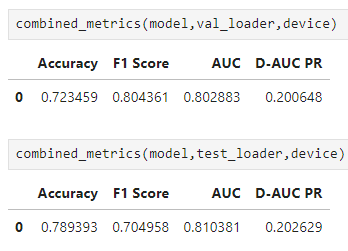

# 7. Compare to Baseline

### RF Training

In [23]:
y_hats_proba, y_hats_class,true_labels = train_rf(sider, data, test_triplet, seed, 1000, shuffle = True)

### Evaluate

In [24]:
eval_rf( y_hats_class,true_labels)

,Accuracy,F1 Score,AUC,D-AUC PR
0,0.518427,0.548678,0.524083,0.00734
